# Grid data from the Plate Boundary Observatory (PBO)



In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dask.distributed import Client, LocalCluster
import itertools
import pyproj
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
from vectorspline3d import VectorSpline3D, VectorSpline3DCV

## Load the data

Load the GPS velocity data as a `pandas.DataFrame`.

In [2]:
data_all = pd.read_csv(
    "../../data/pbo.final_nam08.vel", delim_whitespace=True, skiprows=35, comment="%"
)
data_all["Ref_Elong"] -= 360
data_all.head()

,*Dot#,Name,Ref_epoch,Ref_jday,Ref_X,Ref_Y,Ref_Z,Ref_Nlat,Ref_Elong,Ref_Up...,...,dE/dt,dU/dt,SNd,SEd,SUd,Rne,Rnu,Reu,first_epoch,last_epoch
0,1LSU,Louisiana_St,20171129120000,58086.5,-113402.86448,-5.504361e+06,3.209404e+06,30.407425,-91.180262,-6.56355,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20030423000000,20080621000000
1,1LSU,Louisiana_St,20171129120000,58086.5,-113402.86020,-5.504361e+06,3.209404e+06,30.407425,-91.180262,-6.56999,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20080623000000,20100415000000
2,1LSU,Louisiana_St,20171129120000,58086.5,-113402.86186,-5.504361e+06,3.209404e+06,30.407425,-91.180262,-6.57409,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20100415000000,20140115000000
3,1LSU,Louisiana_St,20171129120000,58086.5,-113402.87074,-5.504361e+06,3.209404e+06,30.407425,-91.180262,-6.56938,...,-0.00030,-0.00282,0.00022,0.00042,0.00046,0.029,0.0,-0.007,20140115000000,20171203000000
4,1NSU,Northwestern,20171129120000,58086.5,-293349.50638,-5.420742e+06,3.336981e+06,31.750801,-93.097603,28.05982,...,-0.00016,-0.00045,0.00026,0.00011,0.00047,-0.056,-0.0,0.038,20040116000000,20100730000000


For now, we'll focus only on the US West coast so let's cut out that portion of the data and cleanup the column names and units.

In [3]:
region = (-125.0, -115.0, 32.5, 43.5)

inside = vd.inside(
    (data_all["Ref_Elong"], data_all["Ref_Nlat"]), 
    region=region
)
# Don' need all the columns. We'll just keep these.
keep_columns = [
    "Ref_Elong", "Ref_Nlat", "dE/dt", "dN/dt", "dU/dt", "SEd", "SNd", "SUd"
]
# Rename the columns to easier to type formats.
new_names = dict(zip(
    keep_columns, 
    ["longitude", "latitude", 
     "east_velocity", "north_velocity", "up_velocity",
     "east_velocity_std", "north_velocity_std", "up_velocity_std"]
))
# Slice and rename the original data
data = data_all.loc[inside, keep_columns].reset_index(drop=True).rename(new_names, axis="columns")
# Convert velocities to mm/yr
data.iloc[:, 2:] *= 1000

# Save the clean and sliced data for later
data.to_csv("../../data/pbo-nam08-us-west-coast.csv", index=False)

print("Number of data points:", data.shape[0])
data.head()

Number of data points: 2538


,longitude,latitude,east_velocity,north_velocity,up_velocity,east_velocity_std,north_velocity_std,up_velocity_std
0,-117.093196,34.116409,-15.73,16.48,2.61,0.37,0.2,0.53
1,-117.093196,34.116409,-15.73,16.48,2.61,0.37,0.2,0.53
2,-117.093195,34.116409,-15.73,16.48,2.61,0.37,0.2,0.53
3,-117.093195,34.116409,-15.73,16.48,2.61,0.37,0.2,0.53
4,-117.093195,34.116409,-15.73,16.48,2.61,0.37,0.2,0.53


## Plot the data

First, we'll make a function to plot our datasets and grids so we don't repeat the same code.

In [4]:
def plot_data(data, ax=None, maxabs=52, every_arrow=2, quiver_scale=400, quiver_width=0.001, size=30):
    "Plot a grid or a DataFrame with the vertical in color and horizontal as vectors."
    crs = ccrs.Mercator()
    transform = ccrs.PlateCarree()
    if ax is None:
        plt.figure(figsize=(11, 16))
        ax = plt.subplot(111, projection=crs)
    ax.add_feature(cfeature.OCEAN, facecolor="skyblue")
    cbargs = dict(orientation="horizontal", aspect=70, label="vertical velocity (mm/yr)",
                  shrink=0.6, pad=0.03)    
    norm = SymLogNorm(linthresh=10, linscale=1, vmin=-maxabs, vmax=maxabs)
    if isinstance(data, pd.DataFrame):
        tmp = ax.scatter(
            data.longitude, data.latitude, s=size, c=data.up_velocity,
            vmin=-maxabs, vmax=maxabs, cmap="seismic", norm=norm,
            transform=transform
        )
        plt.colorbar(tmp, ax=ax, **cbargs)        
    else:
        data.up_velocity.plot.pcolormesh(
            ax=ax, vmin=-maxabs, vmax=maxabs, cmap="seismic", cbar_kwargs=cbargs, 
            add_labels=False, norm=norm, transform=transform, 
        )
        indexer = slice(None, None, every_arrow)
        # Downsample the arrows so we can actually see something
        data = data.isel(longitude=indexer, latitude=indexer)
    ax.quiver(data.longitude.values, data.latitude.values, 
              data.east_velocity.values, data.north_velocity.values, 
              scale=quiver_scale, width=quiver_width, transform=transform)
    #ax.coastlines(resolution="50m", linewidth=1)
    # Set the proper ticks for a Cartopy map
    ax.set_xticks(np.arange(*region[:2], 2)[1:], crs=transform)
    ax.set_yticks(np.arange(*region[2:], 2)[1:], crs=transform)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_extent(region, crs=transform)
    return ax

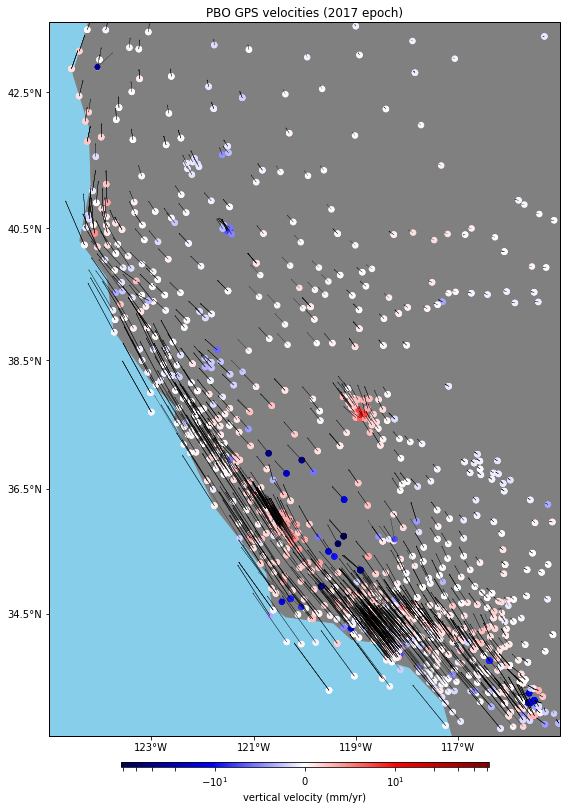

In [ ]:
ax = plot_data(data, quiver_width=0.0005)
ax.set_title("PBO GPS velocities (2017 epoch)")
ax.add_feature(cfeature.LAND, facecolor="gray")

## Projection and weights

Now we can get our data into a format that is more convenient for the gridder class. We also need to set weights based on the variance of the data components and weight each component relative to their amplitudes. This last step is required to avoid having the horizontal components dominating the fit.

In [ ]:
np.linalg.norm(data.up_velocity)/np.linalg.norm(data.east_velocity)

0.2164682677271042

In [ ]:
weights = (
    0.1*vd.variance_to_weights(data.east_velocity_std**2),
    0.1*vd.variance_to_weights(data.north_velocity_std**2),
    1.0*vd.variance_to_weights(data.up_velocity_std**2),
)

Since our gridder is Cartesian, we have to project our data coordinates before gridding.

In [ ]:
projection = pyproj.Proj(proj="aea", lon_0=np.mean(data.longitude.mean()))
proj_coords = projection(data.longitude.values, data.latitude.values)

Finally, gather the training data that we'll use to fit our gridder.

In [ ]:
train = (
    proj_coords,
    (data.east_velocity, data.north_velocity, data.up_velocity),
    weights
)

## Force locations

The forces for the fit will be located on a blocked mean of the data coordinates to avoid aliasing. The blocks will have the final desired grid spacing.

In [ ]:
spacing = 0.1

In [ ]:
blockmean = vd.BlockReduce(reduction=np.mean, spacing=spacing*111e3)
force_coords = blockmean.filter(proj_coords, np.ones(data.shape[0]))[0]
print(force_coords[0].size)

732


Plot the force locations.

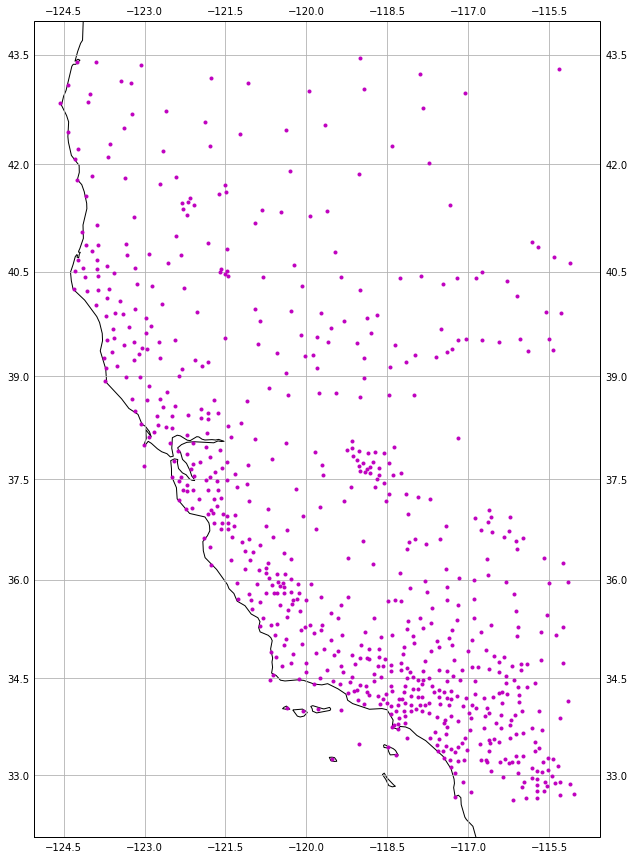

In [ ]:
plt.figure(figsize=(11, 15))
ax = plt.subplot(111, projection=ccrs.Mercator())
plt.plot(*projection(*force_coords, inverse=True), "m.", transform=ccrs.PlateCarree())
ax.coastlines(resolution="50m")
ax.gridlines(draw_labels=True)

## Fit the 3-component spline

Now we can fit our spline to the data. We'll run a grid search with k-fold cross-validation to determine the values for the 4 parameters controlling the gridder performance: damping, Poisson's ratio, depth of the forces, and coupling. Since this is a time consuming process, we'll use a Dask parallel client running locally to do the grid search.

In [ ]:
client = Client(LocalCluster(n_workers=2, threads_per_worker=3))
client

Client Scheduler: tcp://127.0.0.1:38093 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 6 Memory: 12.56 GB


Set the parameter grid for the search and run the cross-validated version of the spline.

In [ ]:
%%time
spline = VectorSpline3DCV(
    poissons=(-1, -0.5, 0, 0.25, 0.5), 
    depths=(0.5e3, 1e3, 1.5e3, 2e3, 2.5e3, 3e3, 4e3, 5e3, 10e3, 15e3),
    dampings=(0.001, 0.01, 0.1, 0.5, 1),
    couplings=(-1, -0.5, 0, 0.5, 1),
    force_coords=force_coords,
    client=client,
)
spline.fit(*train)
print("Best spline configuration:\n", spline.gridder_)
print("Best cross-validation score:", spline.scores_.max())
print("Score on training set:", spline.score(*train))

Calculate the residuals.

In [ ]:
residuals = [o - p for o, p in zip(train[1], spline.predict(proj_coords))]
residuals = dict(zip([c + "_velocity" for c in "east north up".split()], residuals))
residuals.update(dict(longitude=data.longitude, latitude=data.latitude))
residuals = pd.DataFrame(residuals)

residuals.to_csv("../../data/pbo-nam08-3c-spline-residuals.csv", index=False)

residuals.describe()

Plot the residuals.

In [ ]:
ax = plot_data(residuals)
ax.set_title("Residuals (3-component spline)")
ax.add_feature(cfeature.LAND, facecolor="gray")

## Grid the data

Create a land mask to remove the grid points in the oceans using GMT.

In [ ]:
region_str = "/".join(str(i) for i in region)
# Call gmt using the shell
!gmt grdlandmask -Glandmask.nc -I$spacing -R$region_str
with xr.open_dataset("landmask.nc") as ds:
    mask = ds.load()
!rm landmask.nc
mask

Make a geographic grid and mask out the oceans. Save the grid to a netCDF file for later use.

In [ ]:
grid = spline.grid(
    region=region, spacing=spacing, projection=projection,
    dims=["latitude", "longitude"],
    data_names=["east_velocity", "north_velocity", "up_velocity"]
).where(mask.z.values)

grid.to_netcdf("../../data/pbo-nam08-3c-spline-grid.nc")

Plot the grid.

In [ ]:
ax = plot_data(grid, quiver_width=0.001)
ax.set_title("Grided velocities (3-component spline)")
ax.coastlines(resolution="50m", linewidth=1)

## Comparison with the biharmonic spline

Compare our results with 3 independent biharmonic splines. Use the same cross-validation and force coordinates to keep the comparison fair.


In [ ]:
%%time
dampings = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
mindists = [10e3, 20e3, 30e3, 40e3, 50e3, 60e3, 70e3, 80e3, 90e3, 100e3]

parameter_combinations = [
    dict(zip(["damping", "mindist"], combo))
    for combo in itertools.product(dampings, mindists)
]
print("Number of parameter combinations:", len(parameter_combinations))

scores = []
for parameters in parameter_combinations:
    candidate = vd.Vector([
        vd.Spline(force_coords=force_coords, **parameters) for i in range(3)
    ])
    scores.append(client.submit(
        vd.cross_val_score, candidate, *train
    ))
scores = [np.mean(i.result()) for i in scores]

best = np.argmax(scores)
best_parameters = parameter_combinations[best]

spline_single = vd.Vector([
    vd.Spline(force_coords=force_coords, **best_parameters) for i in range(3)
])
spline_single.fit(*train)

print("Best parameters:", best_parameters)
print("Best cross-validation score:", scores[best])
print("Score on training set:", spline_single.score(*train))

Generate a grid using the same configuration as the 3-component spline.

In [ ]:
grid_single = spline_single.grid(
    region=region, spacing=spacing, projection=projection,
    dims=["latitude", "longitude"],
    data_names=["east_velocity", "north_velocity", "up_velocity"]
).where(mask.z.values)
grid_single.to_netcdf("../../data/pbo-nam08-1c-spline-grid.nc")
grid_single

In [ ]:
ax = plot_data(grid_single)
ax.set_title("Gridded velocities (single-component spline)")
ax.coastlines(resolution="50m", linewidth=1)

[]()